In [1]:
# The following file is being used to test the Pipeline
''' Import statements for all the files involved'''
from main import *
from utils import *
from wfield_utils import *
from registration import *
from hemocorrection import *
from denoising import *
from debug_visualize import *
from data_loading_functions import *
from data_preprocessor import *

# Some extra imports we need
from tqdm import tqdm
import pickle
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import timedelta
import cv2
import os

# The folllowing code is from main(). 
# params are global variables used to modify the code
params = {
    'path_to_session_data':       r"C:\Users\evilm\Downloads\07-29-2024",
    'pipe_num':           0,              # select desired pipeline number
    'get_raw_brightness': False,
    'get_DeltaF':         False,
    'get_zScore':         False
          }
# This is inside def main()
# For purposes of testing to visualise the data we will do analysis here.
session_file_paths = get_file_paths(params['path_to_session_data'])
#print(session_file_paths)
# create an obj for each recording within the session
recording = rawDataPreprocessor(params['path_to_session_data'])

print(f'{datetime.datetime.now().time()}: Done loading session data into object')

# Currently 
# recording.all_frames.shape
print(f'{datetime.datetime.now().time()}: Starting Motion Correction')
_, _, recording.all_frames = motion_correct(dat=recording.all_frames, out=None, mode='ecc', apply_shifts=True)
#motion_corrected_frames_all = np.load("registered_stack.npy")
print(f'{datetime.datetime.now().time()}: Done Motion Correction')

blue_frames = recording.all_frames[:,0,...]
analog_data = load_dat_analog(recording.path_to_analog)
frame_times = load_mat_frameTimes(recording.path_to_frameTimes)
blue_ftimes = frame_times['frameTimes']

olfac_matfile = r"C:\Users\evilm\Downloads\07-29-2024\data_mixed_full_grating_OdorStimulus_202407291652168_mat.mat"
olfac_configs = pickle.loads(scipy.io.loadmat(olfac_matfile)['configs'].tostring())
olfac_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(olfac_matfile)['experiment_start_timestamp'].tostring())
#olfac_parameters = pickle.loads(scipy.io.loadmat(olfac_matfile)['parameters'].tostring())
# Skipping software environement
olfac_stim_frame_info = pickle.loads(scipy.io.loadmat(olfac_matfile)['stimulus_frame_info'].tostring())
#olfac_stim_frame_info_text = pickle.loads(scipy.io.loadmat(olfac_matfile)['stimulus_frame_info_text'].tostring())
olfac_user_data = pickle.loads(scipy.io.loadmat(olfac_matfile)['user_data'].tostring())
olfac_sync = scipy.io.loadmat(olfac_matfile)['sync']

10:18:42.328986: Done loading session data into object
10:18:42.329970: Starting Motion Correction


Motion correction: 100%|██████████| 22/22 [03:01<00:00,  8.23s/it]

10:21:45.383372: Done Motion Correction



C:\Users\evilm\AppData\Local\Temp\ipykernel_6328\474710792.py:54: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  olfac_configs = pickle.loads(scipy.io.loadmat(olfac_matfile)['configs'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_6328\474710792.py:55: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  olfac_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(olfac_matfile)['experiment_start_timestamp'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_6328\474710792.py:58: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  olfac_stim_frame_info = pickle.loads(scipy.io.loadmat(olfac_matfile)['stimulus_frame_info'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_6328\474710792.py:60: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  olfac_user_data = pickle.loads(scipy.io.loadmat(olfac_matfile)['user_data'].tostring())


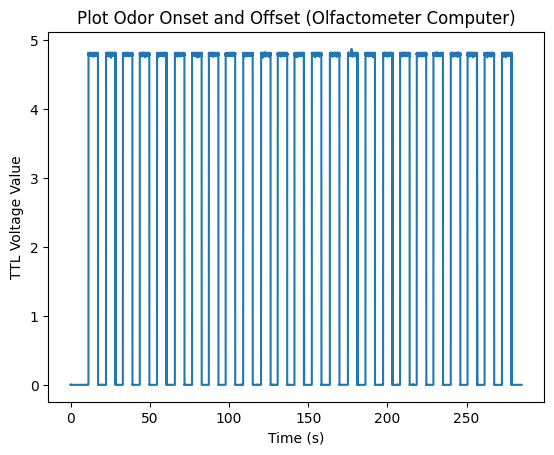

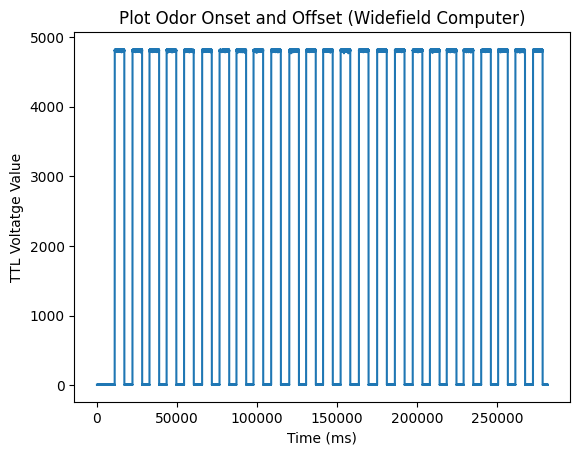

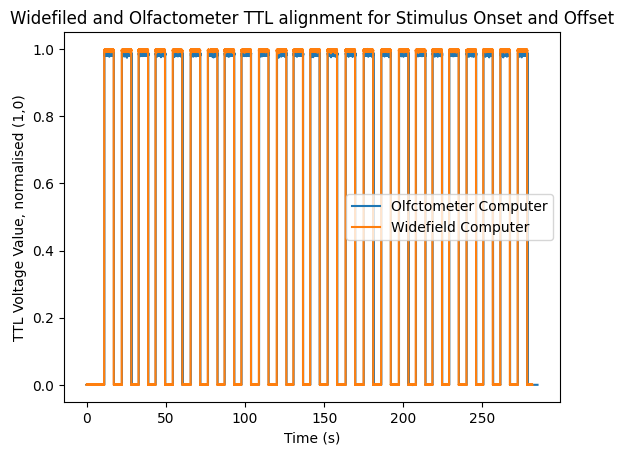

"\nThe code above shows that there is no large difference in the onset of an odor for the olfactometer computer\nand for the widefield computer. So we don't need to do any alignment using the two pulses especially since\nour acquisition rate (40Hz) is much slower then the nano second difference between the two pulses. There\nis a notable difference in the falling of the spike, but we don't care as much about that and only care\nabout the rising spike, as Zoltan has mentioned the falling spike is not as accurate as the rising.\n"

In [2]:
%matplotlib inline
# This line increases the limit of how many points can be plotted on matplotlib
mpl.rcParams['agg.path.chunksize'] = 100000

# Converting the time into seconds, by deafult it is nano, since sampling rate is 10kHz
x_values = np.arange(1, olfac_sync.shape[0] + 1) / 10000

# Plot, remembering olfac_sync[1] is the onset of smell. 
plt.plot(x_values, olfac_sync[:, 1])
plt.xlabel('Time (s)')
plt.ylabel('TTL Voltage Value')
plt.title('Plot Odor Onset and Offset (Olfactometer Computer)')
plt.show()

wf_olfac_signal = np.array(analog_data[0])
plt.plot(wf_olfac_signal[4])
plt.xlabel('Time (ms)')
plt.ylabel('TTL Voltatge Value')
plt.title('Plot Odor Onset and Offset (Widefield Computer)')
plt.show()

# Normalising pulses, to being between 1 and 0. 
normalised_olfac_signal = (olfac_sync[:,1]-np.min(olfac_sync[:,1]))/(np.max(olfac_sync[:,1])-np.min(olfac_sync[:,1]))    
normalised_wf_signal = (wf_olfac_signal[4]-np.min(wf_olfac_signal[4]))/(np.max(wf_olfac_signal[4])-np.min(wf_olfac_signal[4])) 

plt.plot(x_values,normalised_olfac_signal, label="Olfctometer Computer")
x_values_two = np.arange(1, wf_olfac_signal.shape[1] + 1) / 1000
plt.plot(x_values_two,normalised_wf_signal, label="Widefield Computer")
plt.xlabel('Time (s)')
plt.ylabel('TTL Voltage Value, normalised (1,0)')
plt.title('Widefiled and Olfactometer TTL alignment for Stimulus Onset and Offset')
plt.legend()
plt.show()

'''
The code above shows that there is no large difference in the onset of an odor for the olfactometer computer
and for the widefield computer. So we don't need to do any alignment using the two pulses especially since
our acquisition rate (40Hz) is much slower then the nano second difference between the two pulses. There
is a notable difference in the falling of the spike, but we don't care as much about that and only care
about the rising spike, as Zoltan has mentioned the falling spike is not as accurate as the rising.
'''

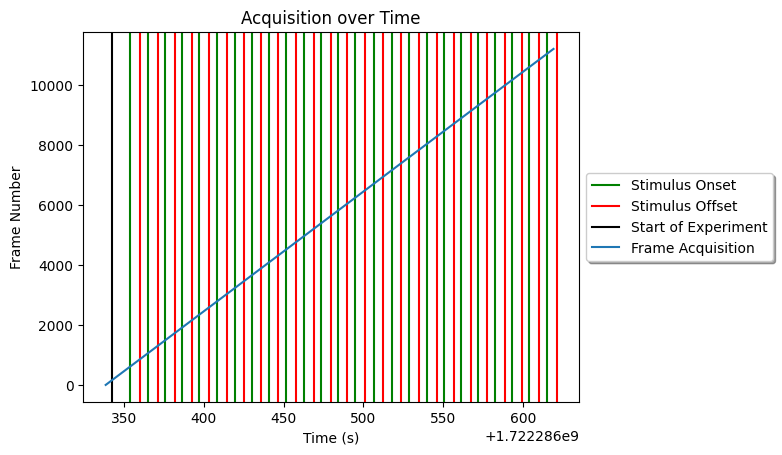

In [3]:
'''
We have to solve the following problem, the widefield computer saves aquisition time in matlab's datetime.datenum function. Which uses
Gregorian time. However our olfactory stimulus computer saves olfactometer onset as Unix time. Since the above diagrams have shown 
that the onset of the olfactometer stimulus release is the same as the widefield computer's record of it. We will use the olfactometer
stimulus frame info which has unix time of onset of stimulus and offset of stimulus. This is how we align and get only frames within the
window of stimulus on. 
'''
# First is a converstion from a matlab datetime to a python datetime in seconds
unix_blueftimes = [datetime.datetime.fromordinal(int(float(f_time)))+timedelta(days=float(f_time)%1)-timedelta(days=366) for (f_time) in blue_ftimes]
# Next is a conversion from python datetime into python unix time, with microsecond precision
unix_blueftimes = [(time.mktime(f_time.timetuple())*1e3 + f_time.microsecond/1e3)/1e3 for f_time in unix_blueftimes]

# Getting out the start times
olfactometer_stimulus_block_times = [float(olfac_stim['time']) for olfac_stim in olfac_stim_frame_info]

plt.figure()
# The following plot will show the onset and offset of stimulus in green
for i,x_coord in enumerate(olfactometer_stimulus_block_times[0::2]):
    if i == 0:
        plt.axvline(x_coord,color='green',label='Stimulus Onset')
    else:
        plt.axvline(x_coord,color='green',label='_nolegend_')
# The following plot will show the onset and offset of stimulus in green
for i,x_coord in enumerate(olfactometer_stimulus_block_times[1::2]):
    if i == 0:
        plt.axvline(x_coord,color='red',label='Stimulus Offset')
    else:
        plt.axvline(x_coord,color='red',label='_nolegend_')
# Start of olfactometer experiment in black
plt.axvline(olfac_experiment_start_timestamp,color='black',label='Start of Experiment')

# Time of frames in blue
plt.plot(unix_blueftimes,np.arange(1,len(unix_blueftimes)+1),label='Frame Acquisition')
plt.xlabel('Time (s)')
plt.ylabel('Frame Number')
# Put a legend below current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True)
plt.title("Acquisition over Time")
plt.show()

In [29]:
'''
Now we have a graph that shows a timed alignment between frame times and is stimulus onset and offset.
We can now do some analysis by seperating baseline images from stimulus images. 
'''
# Turning the olfactometer_stimulus_block_times into a list of tuples, to make the following steps easier
olfactometer_stimulus_block_times = [(olfactometer_stimulus_block_times[i], olfactometer_stimulus_block_times[i + 1]) for i in range(0, len(olfactometer_stimulus_block_times), 2)]
olfactometer_stimulus_block_times = np.array(olfactometer_stimulus_block_times)

# The functon check if a given time falls within any of the specified ranges. 
def is_within_ranges(time,ranges):
    return any(start <= time <= end for start,end in ranges)

# Using list comprehension we generate a binary array of 1,0s. 
# Where 1 means that the frame is within a stimulus time, and a 0 means the frame is outside
# of a stimulus time. 
binary_stim_times = [1 if is_within_ranges(time, olfactometer_stimulus_block_times) else 0 for time in unix_blueftimes]
binary_stim_times = np.array(binary_stim_times)

stimulus_frames = []
baseline_frames = []

# Dividing frames into stim and baseline
for i,frame in enumerate(tqdm(blue_frames)):
    if binary_stim_times[i] == 0:
        baseline_frames.append(frame[:])
    else:
        stimulus_frames.append(frame[:])
stimulus_frames = np.array(stimulus_frames)
baseline_frames = np.array(baseline_frames)

# Generating F
baseline_avg = np.mean(baseline_frames,axis=0)
# Generating delta F over F
# deltaF over F = F(time) - F(baseline) / F(baseline)
for i, frame in enumerate(tqdm(stimulus_frames)):
    stimulus_frames[i] = (frame - baseline_avg) / frame

 99%|█████████▊| 5854/5934 [00:08<00:00, 805.08it/s]C:\Users\evilm\AppData\Local\Temp\ipykernel_89292\2021853265.py:6: RuntimeWarning: divide by zero encountered in divide
  stimulus_frames[i] = (frame - baseline_avg) / frame
100%|██████████| 5934/5934 [00:08<00:00, 730.07it/s]


In [50]:
current_block = []
blocks = []
for value in binary_stim_times:
    if value == 1:
        current_block.append(value)
    else:
        if current_block:
            blocks.append(current_block)
            current_block = []
if current_block:
    blocks.append(current_block)

PRE_FRAMES = 80
POST_FRAMES = 80
LARGEST_STIM_ON_TIME = max(len(block) for block in blocks) if blocks else 0

current_block = []
blocks = []
count = list(binary_stim_times).index(1)

binary_stim_times = np.array(binary_stim_times)
for i, frame in enumerate(tqdm(binary_stim_times[count-80:])):
    counter = 0
    while counter < (count*2 + LARGEST_STIM_ON_TIME):
        current_block.append(frame)
        counter += 1

# matrix_sums = np.sum(stimulus_frames, axis=(1,2))
# index_of_larges = np.argmax(matrix_sums)
# largest_matrix = stimulus_frames[index_of_larges]
# np.max(largest_matrix)
# plt.imshow(largest_matrix)
# plt.show()
# plt.figure
# plt.imshow(baseline_avg,cmap="gray")
# plt.title("Average Baseline Frame")
# plt.show()

# Testing motion correction
#print(f'{datetime.datetime.now().time()}: Starting Motion Correction')
#_, _, motion_corrected_frames_all = motion_correct(dat=recordings['recording_1'].all_frames, out=None, mode='ecc', apply_shifts=True)
#print(f'{datetime.datetime.now().time()}: Done Motion Correction')
#np.save(params['path_to_session_data']+"\motion_corrected_data",motion_corrected_frames_all)

In [42]:
# The following takes the blue frames saves them into jpgs and then converts them to video
for i,frame in enumerate(tqdm(blue_frames)):
    plt.imsave(params["path_to_session_data"] + r"\Data\Frame" + str(i) + ".jpg", frame, cmap='gray')
    
def convert_img_to_video():
    image_folder = r"C:\Users\evilm\Downloads\07-29-2024\Data"
    video_name = r"C:\Users\evilm\Downloads\07-29-2024\Data\video_modified.avi"

    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 7, (width,height))

    for i,image in enumerate(tqdm(images)):
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
convert_img_to_video()

100%|██████████| 11220/11220 [01:26<00:00, 129.41it/s]
